In [22]:
import os
import zipfile
import random
import shutil
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch import nn, optim
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from torchvision.datasets import ImageFolder


In [8]:
BASE_DIR = os.getcwd()
DATASET_PATH = os.path.join(BASE_DIR, "Animals-10.zip")
EXTRACT_PATH = os.path.join(BASE_DIR, "animals_data")
RAW_IMG_PATH = os.path.join(EXTRACT_PATH, "raw-img")
TRAIN_PATH = os.path.join(EXTRACT_PATH, "train")
VAL_PATH = os.path.join(EXTRACT_PATH, "val")
TEST_PATH = os.path.join(EXTRACT_PATH, "test")


In [4]:

def extract_dataset():
    if not os.path.exists(EXTRACT_PATH):
        with zipfile.ZipFile(DATASET_PATH, "r") as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)

def split_data_balanced(train_ratio=0.7, val_ratio=0.15):
    if os.path.exists(TRAIN_PATH): shutil.rmtree(TRAIN_PATH)
    if os.path.exists(VAL_PATH): shutil.rmtree(VAL_PATH)
    if os.path.exists(TEST_PATH): shutil.rmtree(TEST_PATH)

    os.makedirs(TRAIN_PATH)
    os.makedirs(VAL_PATH)
    os.makedirs(TEST_PATH)

    min_images = float('inf')

    class_image_dict = {}
    for class_name in os.listdir(RAW_IMG_PATH):
        class_path = os.path.join(RAW_IMG_PATH, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            class_image_dict[class_name] = images
            if len(images) < min_images:
                min_images = len(images)


    for class_name, images in class_image_dict.items():
        random.shuffle(images)
        images = images[:min_images]

        train_end = int(train_ratio * min_images)
        val_end = train_end + int(val_ratio * min_images)

        paths = {
            'train': os.path.join(TRAIN_PATH, class_name),
            'val': os.path.join(VAL_PATH, class_name),
            'test': os.path.join(TEST_PATH, class_name),
        }

        for path in paths.values():
            os.makedirs(path, exist_ok=True)

        for img in images[:train_end]:
            shutil.copy(os.path.join(RAW_IMG_PATH, class_name, img), os.path.join(paths['train'], img))
        for img in images[train_end:val_end]:
            shutil.copy(os.path.join(RAW_IMG_PATH, class_name, img), os.path.join(paths['val'], img))
        for img in images[val_end:]:
            shutil.copy(os.path.join(RAW_IMG_PATH, class_name, img), os.path.join(paths['test'], img))

In [5]:
def count_images_per_class_in_folder(folder_path):
    print(f"\nNum of images in folder: {folder_path}")
    for class_name in sorted(os.listdir(folder_path)):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            image_count = len(os.listdir(class_folder))
            print(f"{class_name}: {image_count} images")

In [6]:
def plot_class_distribution_from_zip(zip_path):
    class_counts = defaultdict(int)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if file.startswith("raw-img/") and file.lower().endswith(('.jpg', '.jpeg', '.png')):
                parts = file.split("/")
                if len(parts) > 2:
                    class_name = parts[1]
                    class_counts[class_name] += 1

    classes = list(class_counts.keys())
    counts = [class_counts[cls] for cls in classes]

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.title("Number of images by classes")
    plt.ylabel("Number of images")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

На початкових етапах роботи було виявлено, що датасет не було попередньо структуровано відповідно до класів. Це упущення було виправлено перед запуском основних експериментів.

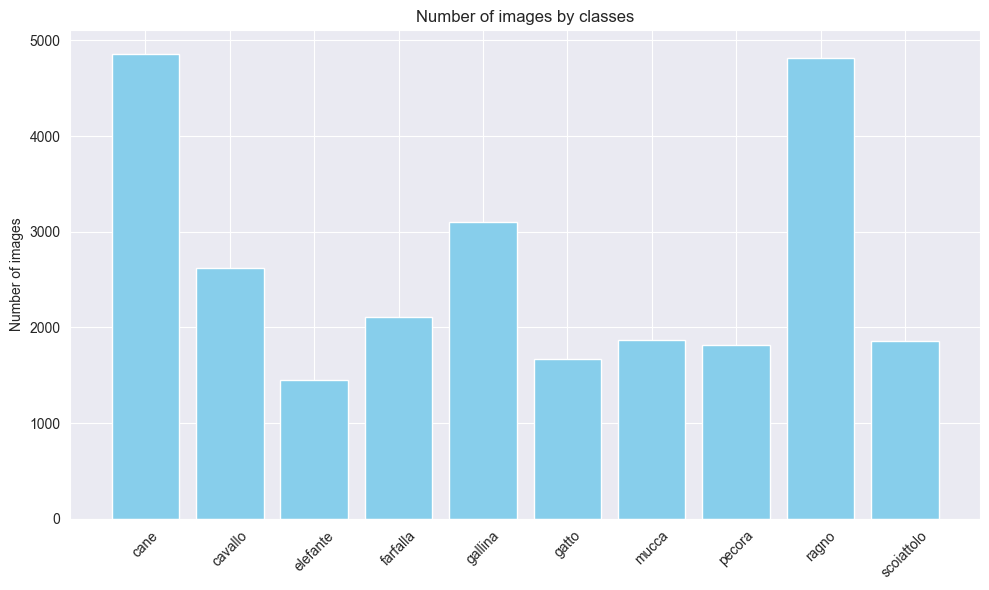


Nun of images in folder: F:\deep_learning\project\animals_data\train
cane: 1012 images
cavallo: 1012 images
elefante: 1012 images
farfalla: 1012 images
gallina: 1012 images
gatto: 1012 images
mucca: 1012 images
pecora: 1012 images
ragno: 1012 images
scoiattolo: 1012 images

Nun of images in folder: F:\deep_learning\project\animals_data\test
cane: 218 images
cavallo: 218 images
elefante: 218 images
farfalla: 218 images
gallina: 218 images
gatto: 218 images
mucca: 218 images
pecora: 218 images
ragno: 218 images
scoiattolo: 218 images

Nun of images in folder: F:\deep_learning\project\animals_data\val
cane: 216 images
cavallo: 216 images
elefante: 216 images
farfalla: 216 images
gallina: 216 images
gatto: 216 images
mucca: 216 images
pecora: 216 images
ragno: 216 images
scoiattolo: 216 images


In [9]:
extract_dataset()
split_data_balanced()
plot_class_distribution_from_zip(DATASET_PATH)

count_images_per_class_in_folder(TRAIN_PATH)
count_images_per_class_in_folder(TEST_PATH)
count_images_per_class_in_folder(VAL_PATH)

Початкова модель, яку я написав, виглядає як показана нижче

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


learning rate знайденний через Optuna

In [ ]:
model = CNNModel(10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000845647)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

З такою моделлю вдалось дійти до 80% accuracy на тестовому датасеті

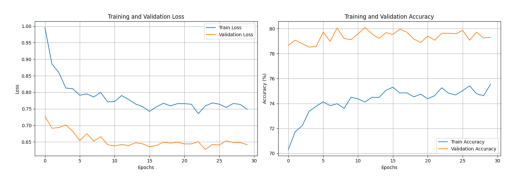

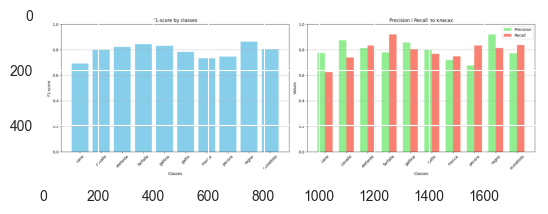

In [6]:
from PIL import Image
image_path = '80accuracy.png'

image = Image.open('80accuracy.png')
image1 = Image.open('80accuracy_f1.png')
plt.imshow(image)

plt.axis('off')
plt.show()
plt.imshow(image1)
plt.show()

Epoch 122/122: 100%|██████████| 159/159 [00:28<00:00,  5.57it/s, acc=91, loss=0.28]   


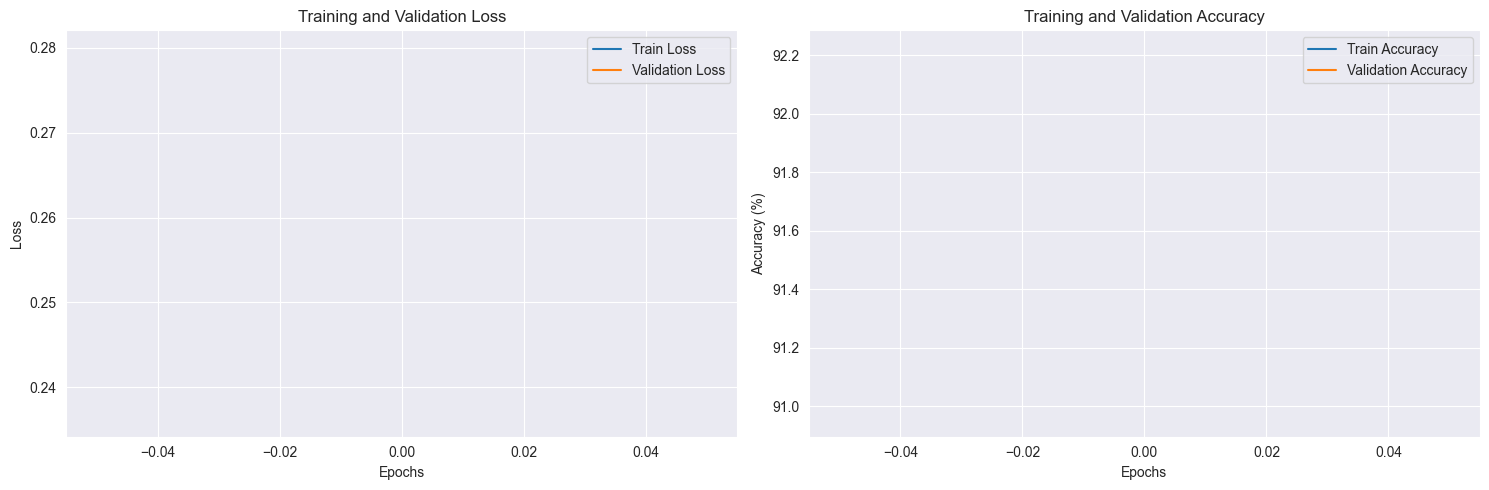


Validation Accuracy: 92.22%

Classification Report:
               precision    recall  f1-score   support

        cane       0.96      0.84      0.90       216
     cavallo       0.89      0.94      0.91       216
    elefante       0.93      0.91      0.92       216
    farfalla       0.89      0.98      0.94       216
     gallina       0.93      0.94      0.94       216
       gatto       0.94      0.92      0.93       216
       mucca       0.89      0.90      0.89       216
      pecora       0.90      0.90      0.90       216
       ragno       0.97      0.93      0.95       216
  scoiattolo       0.93      0.96      0.94       216

    accuracy                           0.92      2160
   macro avg       0.92      0.92      0.92      2160
weighted avg       0.92      0.92      0.92      2160



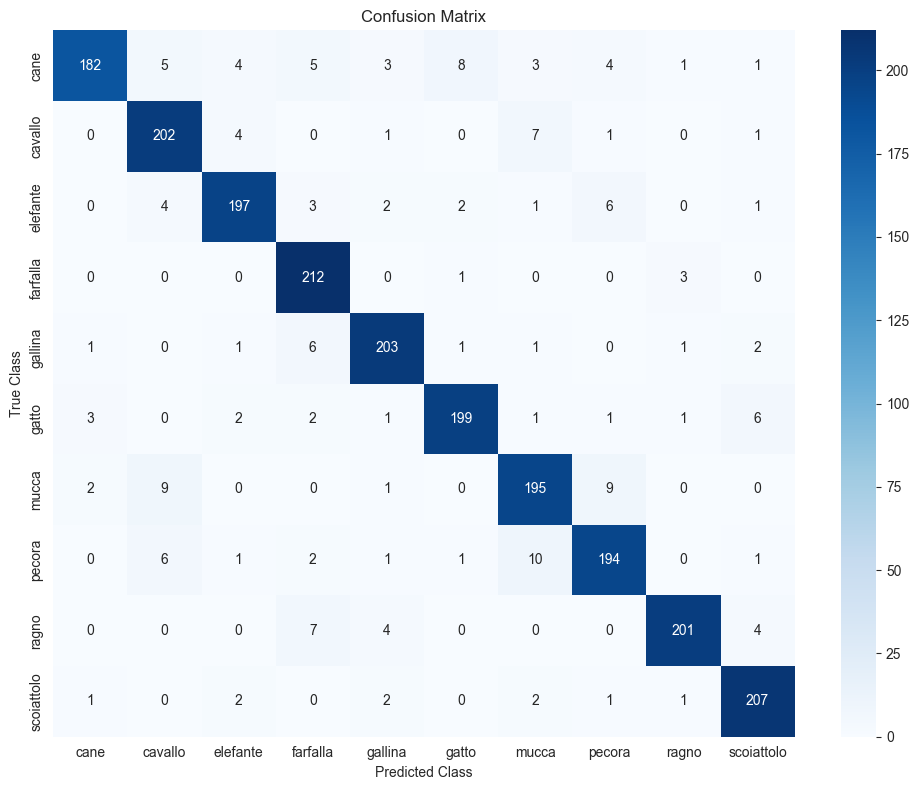

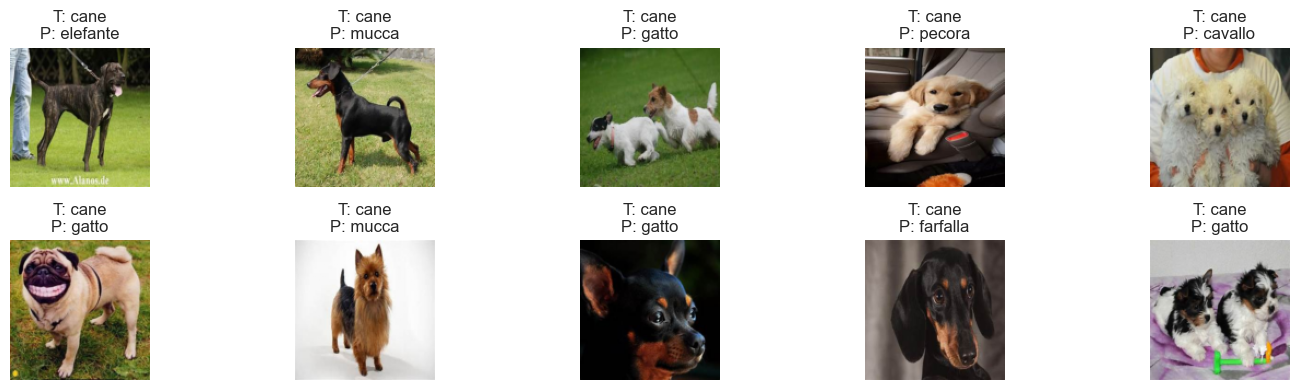

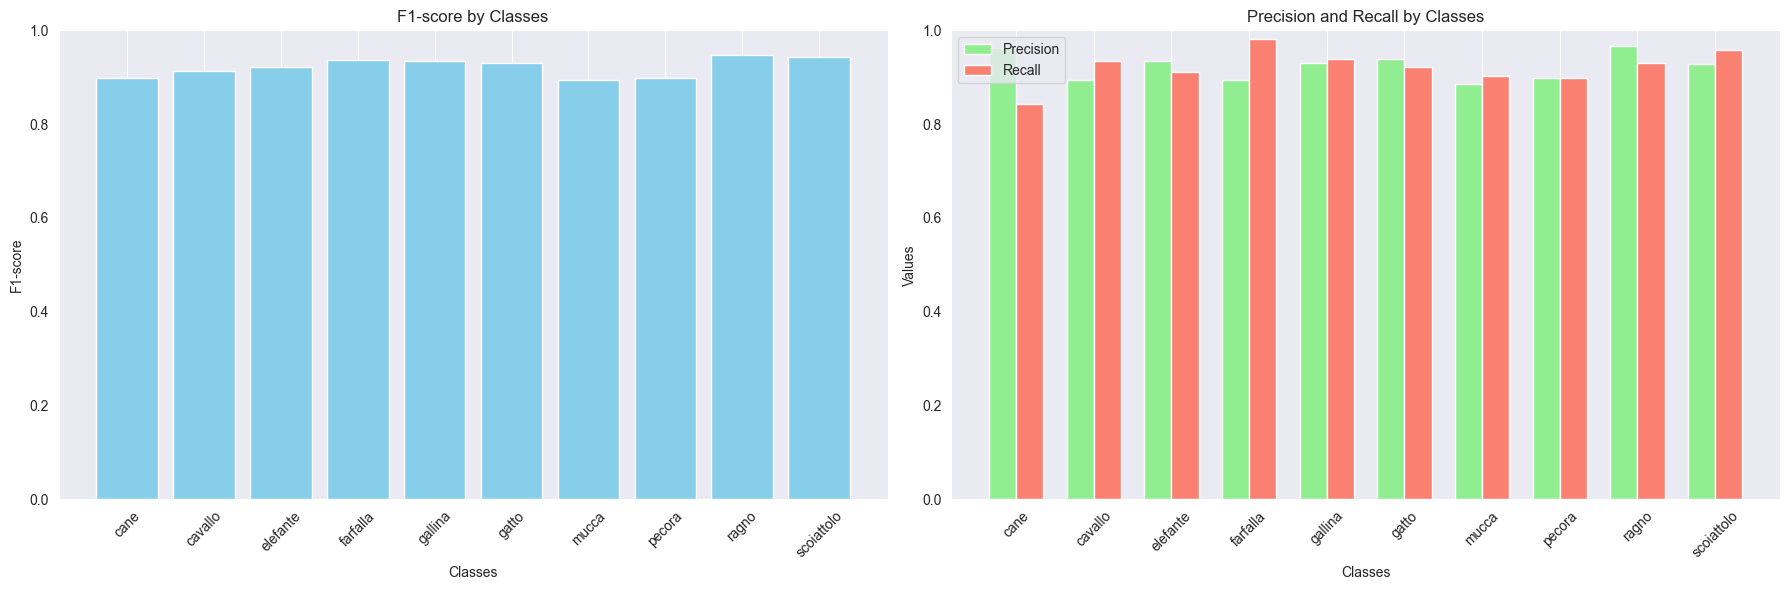

Checkpoint saved to checkpoint_91.pth


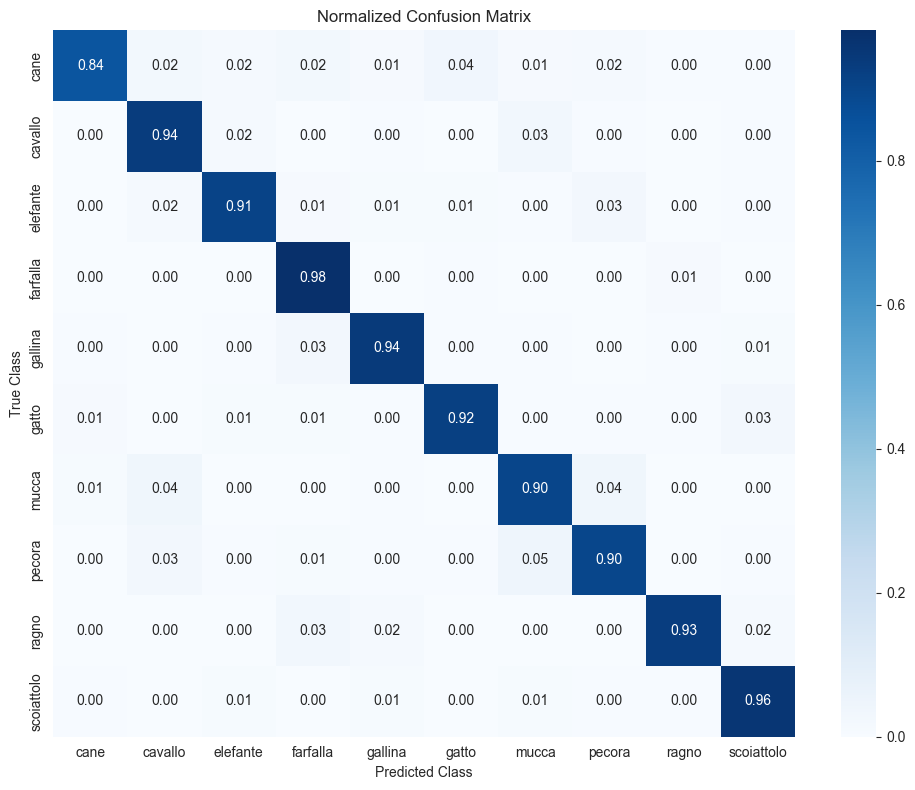

Test Accuracy: 92.98%


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.1),
                nn.MaxPool2d(2)
            )

        self.block1 = conv_block(3, 32)
        self.block2 = conv_block(32, 64)
        self.block3 = conv_block(64, 128)
        self.block4 = conv_block(128, 256)
        self.block5 = conv_block(256, 512)

        self.res1 = nn.Conv2d(3, 64, kernel_size=1, stride=4)
        self.res2 = nn.Conv2d(64, 128, kernel_size=1, stride=2)
        self.res3 = nn.Conv2d(128, 256, kernel_size=1, stride=2)
        self.res4 = nn.Conv2d(256, 512, kernel_size=1, stride=2)

        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.bn_fc = nn.BatchNorm1d(512)
        self.relu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)


    def forward(self, x):
        identity1 = self.res1(x)
        x = self.block1(x)
        x = self.block2(x)
        x += identity1

        identity2 = self.res2(x)
        x = self.block3(x)
        x += identity2

        identity3 = self.res3(x)
        x = self.block4(x)
        x += identity3

        identity4 = self.res4(x)
        x = self.block5(x)
        x += identity4

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

base_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
augmented_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
super_augmented_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.6, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.4),
    transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=base_transforms)
val_dataset = datasets.ImageFolder(VAL_PATH, transform=base_transforms)
test_dataset = datasets.ImageFolder(TEST_PATH, transform=base_transforms)
viz_dataset = datasets.ImageFolder(TEST_PATH, transform=transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()]))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
viz_loader = DataLoader(viz_dataset, batch_size=64, shuffle=False, num_workers=4)

classes = train_dataset.classes
model = CNNModel(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.000001)

def train_model(model, train_loader, val_loader, device, criterion, optimizer, scheduler, epochs, start_epoch=0):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(start_epoch, start_epoch + epochs):

        train_dataset.transform = augmented_transforms

        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        loop = tqdm(train_loader, leave=True)
        loop.set_description(f"Epoch {epoch + 1}/{epochs + start_epoch}")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            loop.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        scheduler.step()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        model.eval()
        val_running_loss = 0.0
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_losses.append(val_running_loss / len(val_loader))
        val_accuracies.append(100 * val_correct / val_total)



    return {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }


def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Графік втрат
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def evaluate_model(model, val_loader, viz_loader, device, classes):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for (images, labels), (viz_images, _) in zip(val_loader, viz_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            mask = (predicted != labels)
            for i, is_wrong in enumerate(mask):
                if is_wrong:
                    misclassified_images.append(viz_images[i].numpy())
                    misclassified_labels.append(labels[i].item())
                    misclassified_preds.append(predicted[i].item())

    accuracy = 100 * correct / total
    print(f"\nValidation Accuracy: {accuracy:.2f}%")

    report = classification_report(all_labels, all_preds, target_names=classes)
    print("\nClassification Report:\n", report)

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    visualize_misclassified(misclassified_images, misclassified_labels, misclassified_preds, classes)

    report_dict = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
    plot_class_metrics(report_dict, classes)

    return accuracy, report_dict


# Function to visualize misclassified images
def visualize_misclassified(images, true_labels, pred_labels, classes, n=10):
    n = min(n, len(images))

    plt.figure(figsize=(15, 2 * ((n + 4) // 5)))
    for i in range(n):
        plt.subplot(((n + 4) // 5), 5, i + 1)

        img = np.transpose(images[i], (1, 2, 0))  # CxHxW -> HxWxC

        plt.imshow(img)
        plt.title(f"T: {classes[true_labels[i]]}\nP: {classes[pred_labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('misclassified_examples.png')
    plt.show()


# Function to visualize metrics by class
def plot_class_metrics(report_dict, classes):
    f1_scores = [report_dict[cls]['f1-score'] for cls in classes]
    precision = [report_dict[cls]['precision'] for cls in classes]
    recall = [report_dict[cls]['recall'] for cls in classes]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # F1-scores
    ax1.bar(classes, f1_scores, color='skyblue')
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('F1-score')
    ax1.set_title('F1-score by Classes')
    ax1.set_ylim(0, 1)
    ax1.grid(axis='y')
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)

    # Precision and Recall
    x = np.arange(len(classes))
    width = 0.35
    ax2.bar(x - width / 2, precision, width, label='Precision', color='lightgreen')
    ax2.bar(x + width / 2, recall, width, label='Recall', color='salmon')
    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Values')
    ax2.set_title('Precision and Recall by Classes')
    ax2.set_xticks(x)
    ax2.set_xticklabels(classes)
    ax2.set_ylim(0, 1)
    ax2.legend()
    ax2.grid(axis='y')
    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)

    plt.tight_layout()
    plt.savefig('class_metrics.png')
    plt.show()


# Function to plot a normalized confusion matrix
def plot_normalized_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.savefig('normalized_confusion_matrix.png')
    plt.show()


# Saving the model after training
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")


# Saving a checkpoint
def save_checkpoint(model, optimizer, scheduler, epoch, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch
    }, path)
    print(f"Checkpoint saved to {path}")


if __name__ == "__main__":
    start_epoch = 0
    checkpoint_path = "checkpoint_91.pth"

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']

    history = train_model(
        model, train_loader, val_loader, device, criterion, optimizer, scheduler,
        epochs=1,
        start_epoch=start_epoch
    )

    plot_training_history(history)
    accuracy, report_dict = evaluate_model(model, val_loader, viz_loader, device, classes)

    save_checkpoint(model, optimizer, scheduler, start_epoch + 1, checkpoint_path)

    with torch.no_grad():
        all_preds, all_labels = [], []
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        plot_normalized_confusion_matrix(all_labels, all_preds, classes)

    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")


Основні особливості в порівнянні з першою моделлю:
Більше блоків:
5 conv_block-ів з глибинами від 3 → 512
Кожен conv_block:
Conv2d
BatchNorm2d
LeakyReLU
MaxPool2d
Додано залишкові з’єднання (residual connections):
x += identity1
Бокові res-гілки (self.res1, ..., self.res4):
1x1 Conv2d шари, які пристосовують розміри для сумування з основним потоком
Глобальні ознаки:
Після convolutions: x.view(...) → fc1 (512*4*4 → 512) → fc2 → fc3
Три повнозв’язні шари, 2 Dropout, нормалізація (BatchNorm1d)
Краще регуляризована:
Dropout (0.5)
BatchNorm для стабільності тренування

З цією моделлю я вже зміг досягти 92 відсотків на валідації, також було багато еспериментів з аугментацією, її поступовим включенням і зміною важкості аугментації, що дозволило моделі в купі з Дропаутом покращити проблему з перенавчанням і стати більш стійкою




In [ ]:
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False

num_classes = 10
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
model = model.to(device)

BASE_DIR = os.getcwd()
DATASET_PATH = os.path.join(BASE_DIR, "Animals-10.zip")
EXTRACT_PATH = os.path.join(BASE_DIR, "animals_data")
RAW_IMG_PATH = os.path.join(EXTRACT_PATH, "raw-img")
TRAIN_PATH = os.path.join(EXTRACT_PATH, "train")
VAL_PATH = os.path.join(EXTRACT_PATH, "val")


base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmented_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

visualization_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=base_transforms)
val_dataset = datasets.ImageFolder(VAL_PATH, transform=val_transform)
viz_dataset = datasets.ImageFolder(VAL_PATH, transform=visualization_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
viz_loader = DataLoader(viz_dataset, batch_size=64, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[-1].parameters(), lr=0.0003)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=10)


def train_model(model, train_loader, val_loader, device, criterion, optimizer, scheduler, epochs=30):
    model.train()

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        if 10 <= epoch <= 26:
            train_dataset.transform = augmented_transforms
        else:
            train_dataset.transform = base_transforms

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        loop = tqdm(train_loader, leave=True)
        loop.set_description(f"Epoch {epoch + 1}/{epochs}")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            loop.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        scheduler.step()

        train_epoch_loss = running_loss / len(train_loader)
        train_epoch_acc = 100 * correct / total
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct, val_total = 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_acc = 100 * val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

    return {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()


def evaluate_model(model, val_loader, viz_loader, device, classes):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for (images, labels), (viz_images, _) in zip(val_loader, viz_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            mask = (predicted != labels)
            for i, is_wrong in enumerate(mask):
                if is_wrong:
                    misclassified_images.append(viz_images[i].numpy())
                    misclassified_labels.append(labels[i].item())
                    misclassified_preds.append(predicted[i].item())

    accuracy = 100 * correct / total
    print(f"\nValidation Accuracy: {accuracy:.2f}%")

    report = classification_report(all_labels, all_preds, target_names=classes)
    print("\nClassification Report:\n", report)

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    visualize_misclassified(misclassified_images, misclassified_labels, misclassified_preds, classes)

    report_dict = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
    plot_class_metrics(report_dict, classes)

    return accuracy, report_dict


def visualize_misclassified(images, true_labels, pred_labels, classes, n=10):
    n = min(n, len(images))
    if n == 0:
        return

    plt.figure(figsize=(15, 2 * ((n + 4) // 5)))
    for i in range(n):
        plt.subplot(((n + 4) // 5), 5, i + 1)

        img = np.transpose(images[i], (1, 2, 0))  # CxHxW -> HxWxC

        plt.imshow(img)
        plt.title(f"T: {classes[true_labels[i]]}\nP: {classes[pred_labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('misclassified_examples.png')
    plt.show()


def plot_class_metrics(report_dict, classes):
    f1_scores = [report_dict[cls]['f1-score'] for cls in classes]
    precision = [report_dict[cls]['precision'] for cls in classes]
    recall = [report_dict[cls]['recall'] for cls in classes]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.bar(classes, f1_scores, color='skyblue')
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('F1-score')
    ax1.set_title('F1-score per class')
    ax1.set_ylim(0, 1)
    ax1.grid(axis='y')
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)

    x = np.arange(len(classes))
    width = 0.35
    ax2.bar(x - width / 2, precision, width, label='Precision', color='lightgreen')
    ax2.bar(x + width / 2, recall, width, label='Recall', color='salmon')
    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Score')
    ax2.set_title('Precision and Recall per class')
    ax2.set_xticks(x)
    ax2.set_xticklabels(classes)
    ax2.set_ylim(0, 1)
    ax2.legend()
    ax2.grid(axis='y')
    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)

    plt.tight_layout()
    plt.savefig('class_metrics.png')
    plt.show()


def plot_normalized_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.savefig('normalized_confusion_matrix.png')
    plt.show()

def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

if __name__ == "__main__":
    classes = train_dataset.classes

    history = train_model(model, train_loader, val_loader, device, criterion, optimizer, scheduler, epochs=45)

    plot_training_history(history)

    accuracy, report_dict = evaluate_model(model, val_loader, viz_loader, device, classes)

    with torch.no_grad():
        all_preds = []
        all_labels = []
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        plot_normalized_confusion_matrix(all_labels, all_preds, classes)

    save_model(model, "best_model_mobilenet_v4.pth")

Test accuracy: 94.50%


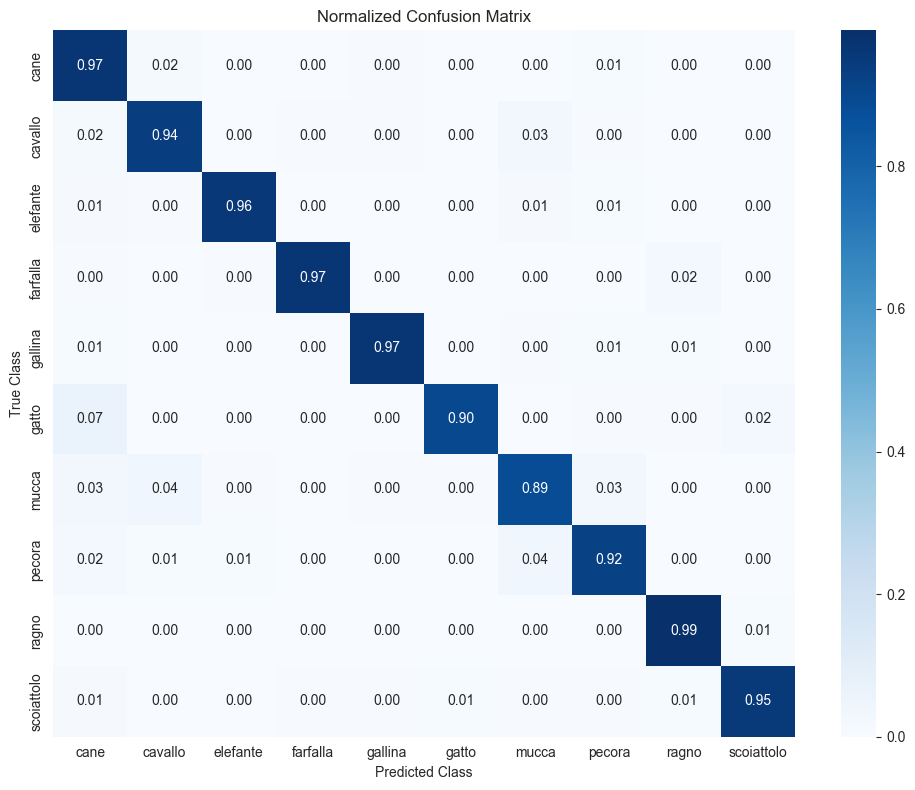


Classification Report:
               precision    recall  f1-score   support

        cane       0.84      0.97      0.90       218
     cavallo       0.93      0.94      0.94       218
    elefante       0.98      0.96      0.97       218
    farfalla       0.99      0.97      0.98       218
     gallina       0.98      0.97      0.97       218
       gatto       0.98      0.90      0.94       218
       mucca       0.91      0.89      0.90       218
      pecora       0.93      0.92      0.92       218
       ragno       0.96      0.99      0.97       218
  scoiattolo       0.97      0.95      0.96       218

    accuracy                           0.94      2180
   macro avg       0.95      0.94      0.95      2180
weighted avg       0.95      0.94      0.95      2180



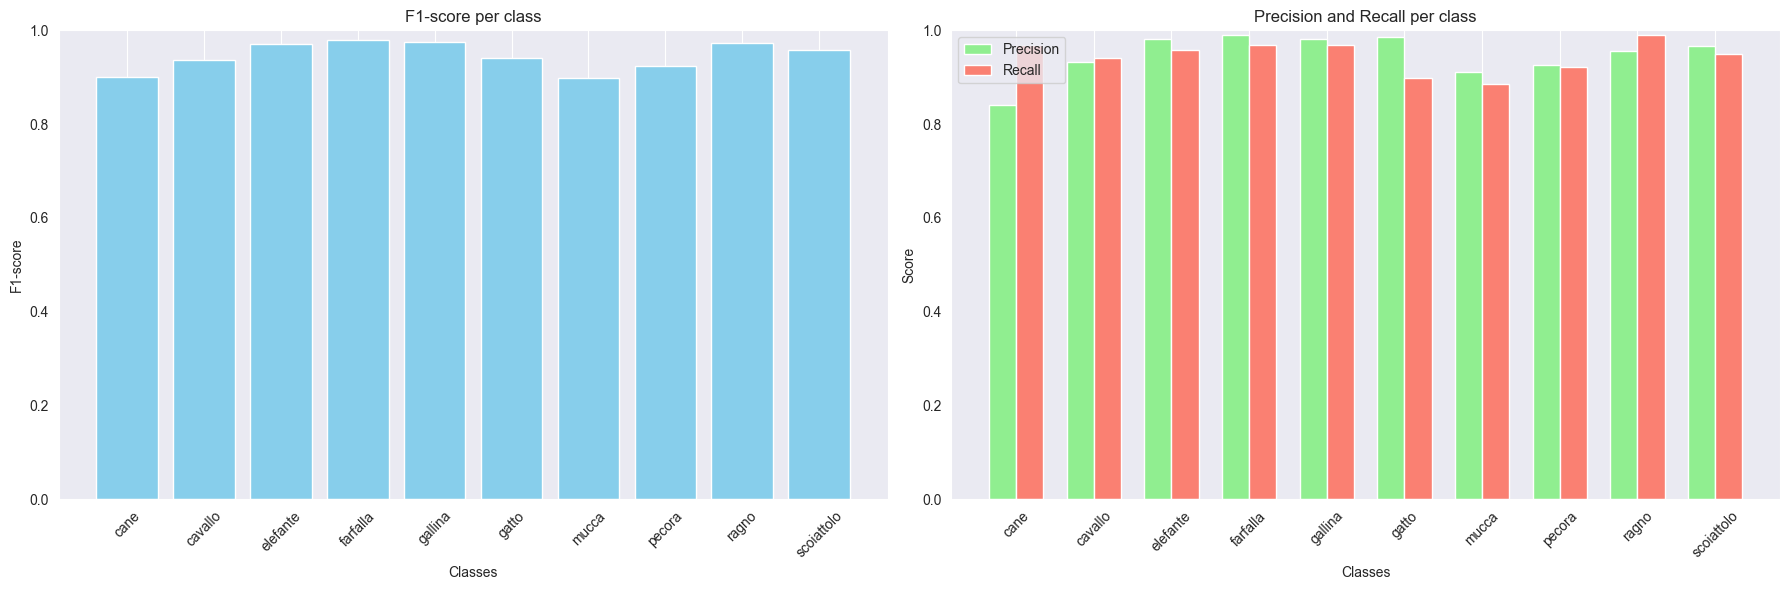

In [25]:
model_path = "best_model_mobilenet_v2.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(TEST_PATH, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"Test accuracy: {accuracy:.2f}%")

plot_normalized_confusion_matrix(all_labels, all_preds, test_dataset.classes)

report_dict = classification_report(all_labels, all_preds, target_names=test_dataset.classes, output_dict=True)
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=test_dataset.classes))

plot_class_metrics(report_dict, test_dataset.classes)

Дякую за огляд моєї роботи